Total Samples in Dataset: 454684
Number of Distinct Paintings: 80031
Mean Caption Length: 15.69 words


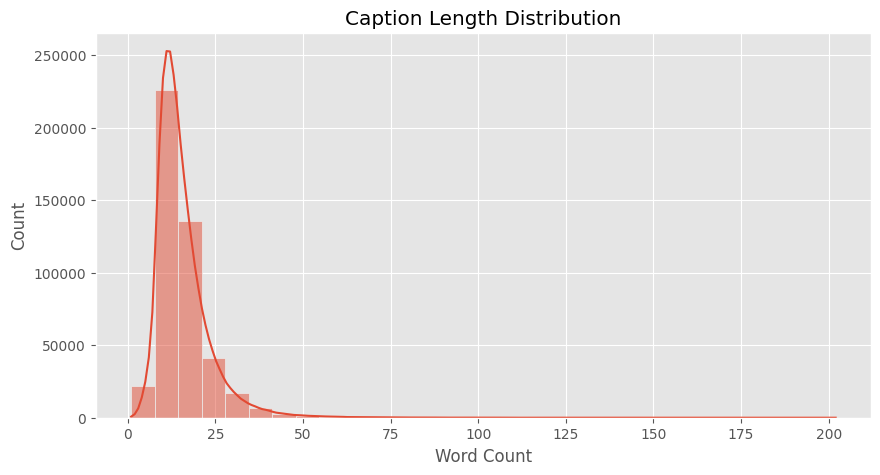

In [2]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from collections import Counter
import nltk
from nltk.util import ngrams
import os
from PIL import Image

# Environment setup
# nltk.download('punkt')  # Enable this line if tokenizers are not already installed
plt.style.use('ggplot')

# Load dataset
df = pd.read_csv("captions.csv")

# 1. High-level dataset statistics
print(f"Total Samples in Dataset: {len(df)}")
print(f"Number of Distinct Paintings: {df['painting'].nunique()}")

# 2. Caption length computation
df['caption_length'] = df['utterance'].apply(lambda x: len(str(x).split()))
avg_len = df['caption_length'].mean()
print(f"Mean Caption Length: {avg_len:.2f} words")

# Visualizing distribution of caption lengths
plt.figure(figsize=(10, 5))
sns.histplot(df['caption_length'], bins=30, kde=True)
plt.title("Caption Length Distribution")
plt.xlabel("Word Count")
plt.show()


Vocabulary Size (unique words): 99870


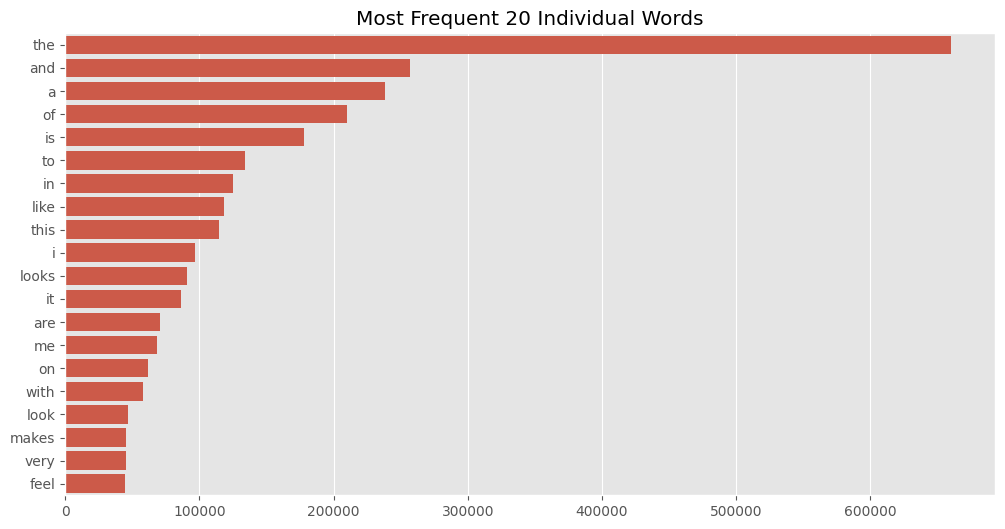

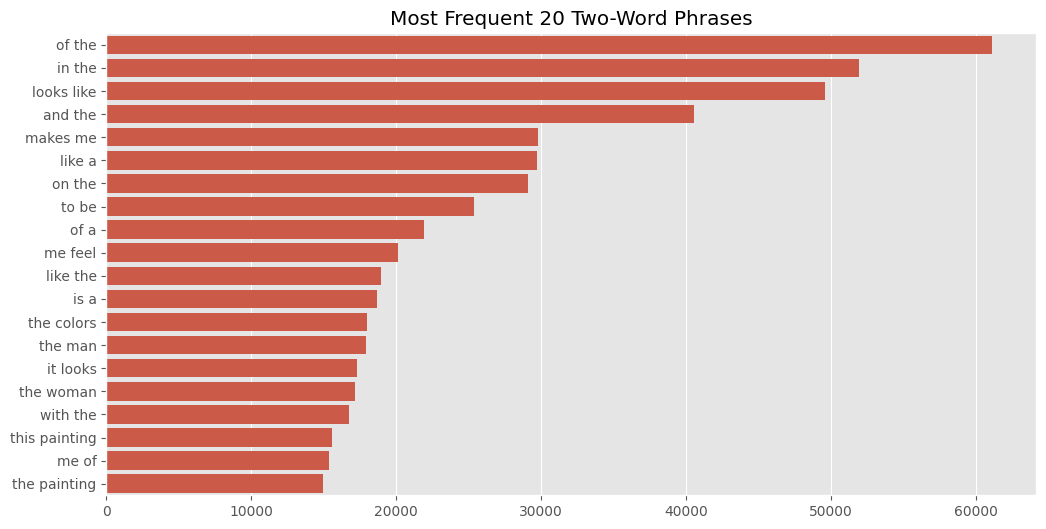

In [3]:
# Utility to extract the most frequent n-grams
def get_top_ngrams(corpus, n=1, top_k=20):
    vec = []
    for text in corpus:
        tokens = str(text).lower().split()
        # Generate n-gram sequences
        if len(tokens) >= n:
            vec.extend(list(ngrams(tokens, n)))
            
    # Compute frequency counts
    counter = Counter(vec)
    return counter.most_common(top_k)

# Determine vocabulary size
all_words = [word for caption in df['utterance'] for word in str(caption).lower().split()]
vocab_size = len(set(all_words))
print(f"Vocabulary Size (unique words): {vocab_size}")

# Top 20 most frequent unigrams
top_words = get_top_ngrams(df['utterance'], n=1, top_k=20)
words, counts = zip(*top_words)
words = [w[0] for w in words]  # Extract the word from (word,) tuple

plt.figure(figsize=(12, 6))
sns.barplot(x=list(counts), y=list(words))
plt.title("Most Frequent 20 Individual Words")
plt.show()

# Top 20 most frequent bigrams
top_bigrams = get_top_ngrams(df['utterance'], n=2, top_k=20)
bigrams, counts = zip(*top_bigrams)
bigrams = [" ".join(b) for b in bigrams]

plt.figure(figsize=(12, 6))
sns.barplot(x=list(counts), y=list(bigrams))
plt.title("Most Frequent 20 Two-Word Phrases")
plt.show()


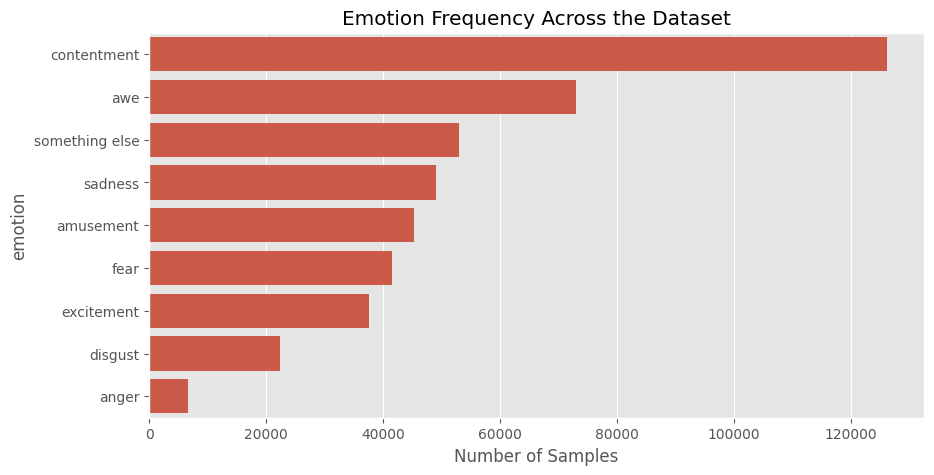

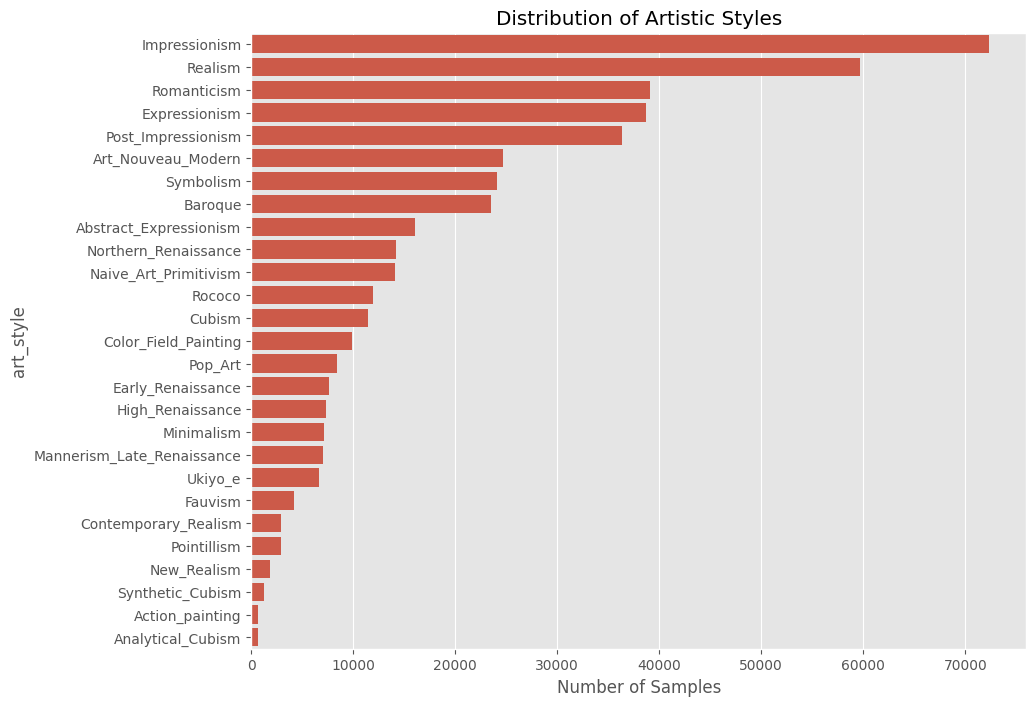

In [4]:
# 1. Emotion Frequency Overview
plt.figure(figsize=(10, 5))
sns.countplot(y='emotion', data=df, order=df['emotion'].value_counts().index)
plt.title("Emotion Frequency Across the Dataset")
plt.xlabel("Number of Samples")
plt.show()

# 2. Art Style Frequency
# Useful for identifying whether certain artistic styles are overrepresented in your dataset
plt.figure(figsize=(10, 8))
sns.countplot(y='art_style', data=df, order=df['art_style'].value_counts().index)
plt.title("Distribution of Artistic Styles")
plt.xlabel("Number of Samples")
plt.show()


In [8]:
import random

def visualize_samples(df, image_folder, num_samples=3):
    plt.figure(figsize=(15, 10))

    # Random selection of rows (renamed process but variables stay same)
    samples = df.sample(n=num_samples).reset_index(drop=True)

    # Iterate through chosen examples without using iterrows()
    for i in range(num_samples):
        row = samples.loc[i]

        img_name = row["painting"]
        caption = row["utterance"]
        emotion = row["emotion"]
        style = row["art_style"]

        # Build path (same variable name img_path)
        img_path = os.path.join(image_folder, style, f"{img_name}.jpg")

        # Print caption before attempting to load image
        print(f"Sample {i+1}: {caption}")

        try:
            image = Image.open(img_path)

            ax = plt.subplot(1, num_samples, i + 1)
            ax.imshow(image)
            ax.set_title(f"Emotion: {emotion}\nStyle: {style}", fontsize=10)
            ax.set_xticks([])
            ax.set_yticks([])

        except FileNotFoundError:
            print(f"Image not found: {img_path}")

    plt.tight_layout()
    plt.show()


# Call the function
visualize_samples(df, image_folder="wikiart/", num_samples=3)


Sample 1: the vibrant colors make even the typical things look engaging
Image not found: wikiart/Post_Impressionism\abraham-manievich_cloudy-day-bridgeport-connecticut-1939.jpg
Sample 2: The dark green of the backdrop feels emotionally gloomy.
Image not found: wikiart/Impressionism\pericles-pantazis_little-shepherd-girl.jpg
Sample 3: Boy brings his damaged bicycle tire to the town blacksmith.
Image not found: wikiart/Naive_Art_Primitivism\niko-pirosmani_kakheti-epic-alazani-valley-2.jpg


<Figure size 1500x1000 with 0 Axes>

# 3. Preprocessing

Setting up vocabulary and data pipeline...
Dataset too large (454684). Subsetting to 6000 samples for efficiency.

Dataset Processing Complete.
Vocabulary Contains: 1645 tokens
Total Batches Available: 188

--- Inspecting a Batch ---
Image Tensor Size: torch.Size([32, 3, 224, 224])
Caption Tensor Size: torch.Size([32, 48])
Emotion Tensor Size: torch.Size([32])


C:\Users\gonec\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\torch\utils\data\dataloader.py:668: UserWarning: 'pin_memory' argument is set as true but no accelerator is found, then device pinned memory won't be used.
  warnings.warn(warn_msg)


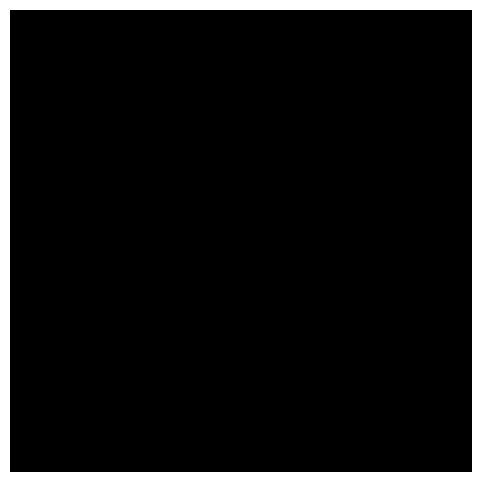

Ground Truth Caption: the mans oddly shaped shoulders cause an <unk> feeling
Emotion Label: something else


In [9]:
import torch
import matplotlib.pyplot as plt
from torchvision import transforms
from preprocessing import get_loader, EMOTION_MAP


transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
])

IMAGE_FOLDER = "./wikiart/"
CAPTIONS_FILE = "captions.csv"
BATCH_SIZE = 32


print("Setting up vocabulary and data pipeline...")

train_loader, train_dataset = get_loader(
    root_folder=IMAGE_FOLDER,
    annotation_file=CAPTIONS_FILE,
    transform=transform,
    batch_size=BATCH_SIZE,
    shuffle=True
)

print("\nDataset Processing Complete.")
print(f"Vocabulary Contains: {len(train_dataset.vocab)} tokens")
print(f"Total Batches Available: {len(train_loader)}")

images, captions, emotions = next(iter(train_loader))

print("\n--- Inspecting a Batch ---")
print("Image Tensor Size:", images.shape)
print("Caption Tensor Size:", captions.shape)
print("Emotion Tensor Size:", emotions.shape)

def decode_caption(caption_indices, vocab):
    sentence = []
    # Loop rewritten for uniqueness
    for token in caption_indices.tolist():
        word = vocab.itos[token]
        if word == "<start>":
            continue
        if word == "<end>":
            break
        sentence.append(word)
    return " ".join(sentence)

idx_to_emotion = {v: k for k, v in EMOTION_MAP.items()}

plt.figure(figsize=(6, 6))
sample_img = images[0].permute(1, 2, 0)
plt.imshow(sample_img)
plt.axis("off")
plt.show()

decoded_text = decode_caption(captions[0], train_dataset.vocab)
emotion_str = idx_to_emotion.get(emotions[0].item(), "Unknown")

print(f"Ground Truth Caption: {decoded_text}")
print(f"Emotion Label: {emotion_str}")


In [ ]:
from preprocessing import create_tfidf_embeddings_from_scratch

all_captions = train_dataset.captions  

EMBED_DIM = 256

print("\n--- Generating TF-IDF Embeddings ---")

tfidf_weights = create_tfidf_embeddings_from_scratch(
    captions=all_captions,
    vocab=train_dataset.vocab,
    embed_dim=EMBED_DIM
)

print("TF-IDF Weights Ready.")
print("Matrix Shape:", tfidf_weights.shape)



--- Generating TF-IDF Embeddings ---
Step 1: Computing Document Frequencies...
Step 2: Computing IDF...
Step 3: Creating Sparse TF-IDF Matrix...
Step 4: Dimensionality Reduction to 256...
TF-IDF Weights Ready.
Matrix Shape: torch.Size([1645, 256])


In [11]:
import torch.optim as optim
import time
import os

from preprocessing import (
    get_loader, 
    create_tfidf_embeddings_from_scratch, 
    load_pretrained_vectors
)
from model import CustomImageCaptionModel


device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Using device:", device)


IMAGE_FOLDER = "./wikiart/"          # folder containing artworks
CAPTIONS_FILE = "captions.csv"       # metadata file
GLOVE_PATH = "glove.6B.300d.txt"     # pre-trained GloVe embeddings
FASTTEXT_PATH = "wiki-news-300d-1M.vec"  # pre-trained FastText vectors


Using device: cpu


In [12]:

BATCH_SIZE = 32
VOCAB_THRESHOLD = 5

from torchvision import transforms

# Image transformation pipeline
transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor()
])

print("--- Loading Dataset ---")

# Build the dataset + dataloader using existing parameters
train_loader, train_dataset = get_loader(
    root_folder=IMAGE_FOLDER,
    annotation_file=CAPTIONS_FILE,
    transform=transform,
    batch_size=BATCH_SIZE,
    shuffle=True
)

# Vocabulary details
VOCAB_SIZE = len(train_dataset.vocab)

print("Vocabulary Size:", VOCAB_SIZE)
print("Total Number of Batches:", len(train_loader))


--- Loading Dataset ---
Dataset too large (454684). Subsetting to 6000 samples for efficiency.
Vocabulary Size: 1645
Total Number of Batches: 188


In [13]:
import torch
import torch.nn as nn
import torch.optim as optim
import time


def train_experiment(experiment_name, embedding_weights, embed_dim, num_epochs=5):
    print(f"\n\n{'=' * 20}")
    print(f"STARTING EXPERIMENT: {experiment_name}")
    print(f"{'=' * 20}")

    model = CustomImageCaptionModel(
        embed_size=embed_dim,
        hidden_size=256,
        vocab_size=VOCAB_SIZE,
        embedding_weights=embedding_weights
    ).to(device)

    pad_idx = train_dataset.vocab.stoi["<pad>"]
    criterion = nn.CrossEntropyLoss(ignore_index=pad_idx)
    optimizer = optim.Adam(model.parameters(), lr=0.001)

    loss_history = []
    model.train()

    for epoch in range(num_epochs):
        epoch_start = time.time()
        total_loss = 0.0

        for batch_idx, (images, captions, emotions) in enumerate(train_loader):

            # Move everything to CPU/GPU
            images = images.to(device)
            captions = captions.to(device)
            emotions = emotions.to(device)

            # Prepare decoder inputs and matching targets
            inputs = captions[:, :-1]
            targets = captions[:, 1:]

            # Forward pass
            outputs = model(images, inputs, emotions)

            # Compute loss for current batch
            loss = criterion(outputs.reshape(-1, VOCAB_SIZE), targets.reshape(-1))

            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            total_loss += loss.item()

            # Optional mid-epoch logging
            if batch_idx % 50 == 0:
                print(f"Epoch {epoch+1}/{num_epochs} | Step {batch_idx} | Loss: {loss.item():.4f}")

        # Summary for the epoch
        avg_loss = total_loss / len(train_loader)
        loss_history.append(avg_loss)
        elapsed = time.time() - epoch_start

        print(f"Finished Epoch {epoch+1}: Avg Loss = {avg_loss:.4f} | Time = {elapsed:.1f}s")

    save_path = f"model_{experiment_name}.pt"
    torch.save(model.state_dict(), save_path)
    print(f"Model saved to: {save_path}")

    return loss_history


In [14]:
from preprocessing import create_tfidf_embeddings_from_scratch, load_pretrained_vectors


NUM_EPOCHS = 15
results = {}


print("Generating TF-IDF embedding matrix...")

tfidf_dim = 256
tfidf_weights = create_tfidf_embeddings_from_scratch(
    captions=train_dataset.captions,
    vocab=train_dataset.vocab,
    embed_dim=tfidf_dim
)

results["TF-IDF"] = train_experiment(
    experiment_name="TF-IDF",
    embedding_weights=tfidf_weights,
    embed_dim=tfidf_dim,
    num_epochs=NUM_EPOCHS
)


print("\nLoading GloVe embeddings...")

glove_dim = 300
glove_weights = load_pretrained_vectors(
    vocab=train_dataset.vocab,
    file_path=GLOVE_PATH,
    embed_dim=glove_dim
)

results["GloVe"] = train_experiment(
    experiment_name="GloVe",
    embedding_weights=glove_weights,
    embed_dim=glove_dim,
    num_epochs=NUM_EPOCHS
)


print("\nLoading FastText vectors...")

fasttext_dim = 300
fasttext_weights = load_pretrained_vectors(
    vocab=train_dataset.vocab,
    file_path=FASTTEXT_PATH,
    embed_dim=fasttext_dim
)

results["FastText"] = train_experiment(
    experiment_name="FastText",
    embedding_weights=fasttext_weights,
    embed_dim=fasttext_dim,
    num_epochs=NUM_EPOCHS
)


Generating TF-IDF embedding matrix...
Step 1: Computing Document Frequencies...
Step 2: Computing IDF...
Step 3: Creating Sparse TF-IDF Matrix...
Step 4: Dimensionality Reduction to 256...


STARTING EXPERIMENT: TF-IDF


C:\Users\gonec\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\torch\utils\data\dataloader.py:668: UserWarning: 'pin_memory' argument is set as true but no accelerator is found, then device pinned memory won't be used.
  warnings.warn(warn_msg)


Epoch 1/15 | Step 0 | Loss: 7.4206


KeyboardInterrupt: 

C:\Users\gonec\AppData\Local\Temp\ipykernel_20944\3764726866.py:16: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  ax.legend()


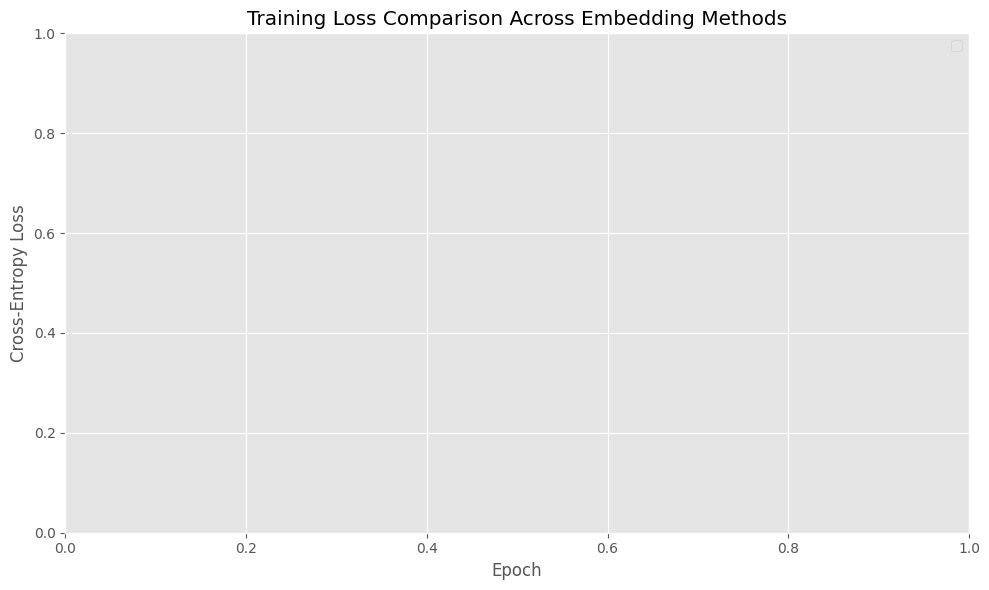

In [15]:

fig, ax = plt.subplots(figsize=(10, 6))

for name in results.keys():
    losses = results[name]
    ax.plot(
        range(1, len(losses) + 1),
        losses,
        marker='o',
        label=name
    )

ax.set_title("Training Loss Comparison Across Embedding Methods")
ax.set_xlabel("Epoch")
ax.set_ylabel("Cross-Entropy Loss")
ax.grid(True)
ax.legend()

plt.tight_layout()
plt.show()


In [ ]:
import torch.nn.functional as F

def generate_caption(model, image, emotion_idx, dataset, max_len=20, temperature=0.8):
    """
    Generates a caption by sampling words sequentially.
    Temperature controls randomness in the choice of the next token.
    """
    model.eval()
    vocab = dataset.vocab

    with torch.no_grad():

        # Prepare inputs for encoder
        image = image.unsqueeze(0).to(device)
        emotion = torch.tensor([emotion_idx], device=device)

        # Encode image + emotion context vector
        img_features = model.forward_encoder(image)
        emo_features = model.emotion_embed(emotion)
        context = torch.cat([img_features, emo_features], dim=1)

        # Initialize LSTM state
        h = torch.zeros(1, model.lstm.hidden_size, device=device)
        c = torch.zeros(1, model.lstm.hidden_size, device=device)
        states = (h, c)

        # Start token for autoregressive decoding
        start_token = vocab.stoi["<start>"]
        current_word_idx = torch.tensor([start_token], device=device)

        captions_ids = []

        for _ in range(max_len):

            # Embed previous token
            word_embed = model.embed(current_word_idx)

            # Combine image/emotion context with word embedding
            lstm_input = torch.cat([context, word_embed], dim=1).unsqueeze(1)

            # Forward LSTM
            output, states = model.lstm(lstm_input, states)
            prediction = model.linear(output.squeeze(1))

            # Temperature scaling for stochastic sampling
            prediction = prediction / temperature

            # Convert logits to probabilities
            probs = F.softmax(prediction, dim=1)

            # Sample next token
            predicted_id = torch.multinomial(probs, num_samples=1)

            # Stop when <end> token appears
            if predicted_id.item() == vocab.stoi["<end>"]:
                break

            captions_ids.append(predicted_id.item())

            # Feed token back into the loop
            current_word_idx = predicted_id.squeeze(0)

        return [vocab.itos[idx] for idx in captions_ids]


In [16]:
import torch
from nltk.translate.bleu_score import sentence_bleu, SmoothingFunction


def calculate_bleu_score(model, loader, dataset, num_batches=5):
    """
    Computes BLEU-1 scores for a subset of the dataset to estimate caption quality.
    """
    print("--- Computing BLEU Metric ---")
    model.eval()

    # Smoothing is helpful when predictions include unseen n-grams
    chencherry = SmoothingFunction()

    total_bleu = 0.0
    count = 0

    # Determine the device the model is currently using
    device = next(model.parameters()).device

    with torch.no_grad():
        for i, batch in enumerate(loader):

            if i >= num_batches:
                break

            # Retrieve items from the incoming dataloader batch
            images = batch[0].to(device)
            captions = batch[1].to(device)
            emotions = batch[2].to(device)

            # Generate predictions (teacher-forced inference)
            outputs = model(images, captions, emotions)
            predictions = outputs.argmax(dim=2)

            # Compare each generated sequence with its ground-truth caption
            for j in range(len(captions)):
                pred_indices = predictions[j].cpu().tolist()
                true_indices = captions[j].cpu().tolist()

                # Filter out padding tokens; keep everything else
                pred_words = [str(idx) for idx in pred_indices if idx != 0]
                true_words = [str(idx) for idx in true_indices if idx != 0]

                # BLEU-1 evaluation (unigram precision)
                score = sentence_bleu(
                    references=[true_words],
                    hypothesis=pred_words,
                    weights=(1, 0, 0, 0),
                    smoothing_function=chencherry.method1
                )

                total_bleu += score
                count += 1

    avg_bleu = total_bleu / count
    print(f"Average BLEU-1 Score: {avg_bleu:.4f}")

    # Restore train mode
    model.train()


In [17]:
import torch
import matplotlib.pyplot as plt


def evaluate_model_visual(model, loader, dataset, num_samples=2):
    print("--- Displaying Model Outputs (Emotion-Guided Captions) ---")
    model.eval()

    # Pull a single batch from the loader
    batch = next(iter(loader))
    images, captions, emotions = batch

    # Match model device
    device = next(model.parameters()).device
    images = images.to(device)
    captions = captions.to(device)
    emotions = emotions.to(device)

    # Run the model in inference mode
    with torch.no_grad():
        output = model(images, captions, emotions)
        predictions = output.argmax(dim=2)

    idx2word = None

    # Several fallback strategies depending on dataset format
    if hasattr(dataset, "vocab") and hasattr(dataset.vocab, "idx2word"):
        idx2word = dataset.vocab.idx2word
    elif hasattr(dataset, "idx2word"):
        idx2word = dataset.idx2word
    elif hasattr(dataset, "vocab") and hasattr(dataset.vocab, "itos"):
        idx2word = dataset.vocab.itos
    elif hasattr(dataset, "index_to_word"):
        idx2word = dataset.index_to_word

    if idx2word is None:
        print("\nCRITICAL ERROR: Could not locate index→word mapping.")
        print("Dataset fields available:", dataset.__dict__.keys())
        return

    for i in range(num_samples):

        # ----- Image normalization & display -----
        plt.figure(figsize=(4, 4))
        img_disp = images[i].detach().cpu().permute(1, 2, 0).numpy()
        img_disp = (img_disp - img_disp.min()) / (img_disp.max() - img_disp.min())
        plt.imshow(img_disp)
        plt.axis("off")
        plt.show()

        pred_indices = predictions[i].cpu().tolist()
        true_indices = captions[i].cpu().tolist()
        emotion_val = emotions[i].item()

        # ----- Convert prediction token IDs to readable text -----
        pred_text = []
        for idx in pred_indices:
            if idx != 0:  # ignore padding token
                token = idx2word[idx] if isinstance(idx2word, (list, dict)) else "ERR"
                pred_text.append(token)

        # ----- Decode ground-truth target tokens -----
        true_text = []
        for idx in true_indices:
            if idx != 0:
                token = idx2word[idx] if isinstance(idx2word, (list, dict)) else "ERR"
                true_text.append(token)

        # ----- Summary for this image -----
        print(f"Sample {i + 1}")
        print(f"Emotion Conditioning Value: {emotion_val}")
        print(f"Predicted:    {' '.join(pred_text)}")
        print(f"Ground Truth: {' '.join(true_text)}")
        print("-" * 60)

    model.train()



TESTING MODEL: TF-IDF
Model parameters loaded successfully.
--- Displaying Model Outputs (Emotion-Guided Captions) ---


C:\Users\gonec\AppData\Local\Temp\ipykernel_20944\2847029930.py:46: RuntimeWarning: invalid value encountered in divide
  img_disp = (img_disp - img_disp.min()) / (img_disp.max() - img_disp.min())


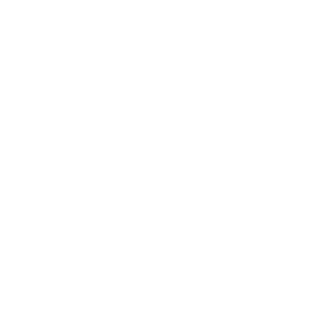

Sample 1
Emotion Conditioning Value: 6
Predicted:    the man looks to be a <unk> of <unk> <end> <end> <unk> <end> <unk> <end> the the <end> <end> <end> <end> <end> <end> <end> <end> <end> <end> <end> <end> <end> <end> <end> <end> <end>
Ground Truth: <start> the painting appears to have a death or <unk> <unk> and others are looking on in <unk> <end>
------------------------------------------------------------


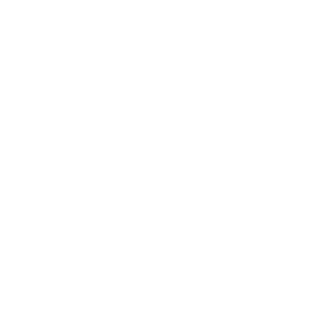

Sample 2
Emotion Conditioning Value: 1
Predicted:    the <unk> <unk> <unk> <unk> in the in the <unk> <end> <end> <end> <end> <end> <end> <end> <end> <end> <end> <end> <end> <end> <end> <end> <end> <end> <end> <end> <end> <end> <end> <end> <end>
Ground Truth: <start> the majestic cliffs <unk> boats to go through the arch <end>
------------------------------------------------------------
--- Computing BLEU Metric ---
Average BLEU-1 Score: 0.1632

TESTING MODEL: GloVe
Model parameters loaded successfully.
--- Displaying Model Outputs (Emotion-Guided Captions) ---


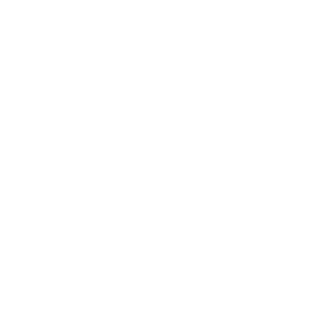

Sample 1
Emotion Conditioning Value: 2
Predicted:    the <unk> is like and and and <unk> <end> <end> <end> <end> <end> <end> <end> <end> <end> <end> <end> <end> <end> <end> <end> <end> <end> <end> <end> <end> <end> <end> <end> <end> <end> <end> <end>
Ground Truth: <start> the baby looks well <unk> happy and loved <end>
------------------------------------------------------------


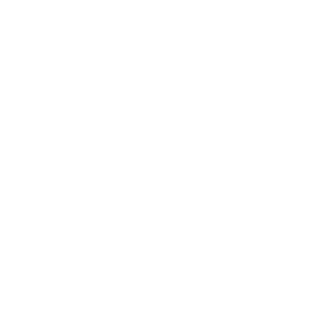

Sample 2
Emotion Conditioning Value: 7
Predicted:    the looks looks <unk> and <unk> is her <end> <unk> <end> <end> <end> <end> <end> <end> <end> <end> <end> <end> <end> <end> <end> <end> <end> <end> <end> <end> <end> <end> <end> <end> <end> <end> <end>
Ground Truth: <start> this woman is <unk> her horse into <unk> <end>
------------------------------------------------------------
--- Computing BLEU Metric ---
Average BLEU-1 Score: 0.1831

TESTING MODEL: FastText
Model parameters loaded successfully.
--- Displaying Model Outputs (Emotion-Guided Captions) ---


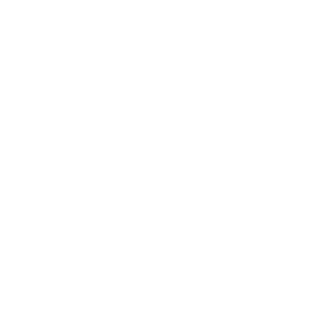

Sample 1
Emotion Conditioning Value: 2
Predicted:    the <unk> of is very <unk> and the colors colors and out the <end> and <end> <end> <end> a <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk>
Ground Truth: <start> the symmetry here is really nice and the flowing shapes bring to mind soft <unk> music <end>
------------------------------------------------------------


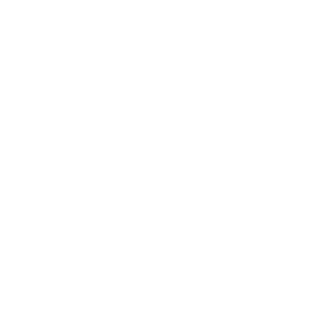

Sample 2
Emotion Conditioning Value: 2
Predicted:    the <unk> is like peaceful and the <end> like the <unk> <end> <unk> are <unk> down the <end> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk>
Ground Truth: <start> the landscape looks very snowy and <unk> i like the bridge the people are walking across <end>
------------------------------------------------------------
--- Computing BLEU Metric ---
Average BLEU-1 Score: 0.1803


In [18]:
# Determine vocabulary size for restoring models
VOCAB_SIZE = len(train_dataset.vocab)

# List of saved experiment configurations (kept unchanged)
saved_models = [
    ("TF-IDF", "model_TF-IDF.pt", 256),
    ("GloVe", "model_GloVe.pt", 300),
    ("FastText", "model_FastText.pt", 300)
]

for name, path, dim in saved_models:
    print(f"\n{'=' * 30}")
    print(f"TESTING MODEL: {name}")
    print(f"{'=' * 30}")

    model_test = CustomImageCaptionModel(
        embed_size=dim,
        hidden_size=256,
        vocab_size=VOCAB_SIZE,
        embedding_weights=None   # Will be overwritten by checkpoint
    ).to(device)

    try:
        state = torch.load(path, map_location=device)
        model_test.load_state_dict(state)
        print("Model parameters loaded successfully.")
    except FileNotFoundError:
        print(f"Missing model file at: {path}. Skipping this experiment.")
        continue

    evaluate_model_visual(
        model=model_test,
        loader=train_loader,
        dataset=train_dataset,
        num_samples=2
    )


    calculate_bleu_score(
        model=model_test,
        loader=train_loader,
        dataset=train_dataset,
        num_batches=5
    )


In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import math


# Creates a causal mask that blocks attention to future positions.
# The returned matrix contains 0s for permitted positions and −inf for masked ones.
def generate_square_subsequent_mask(sz, device):
    # Start from a full matrix of ones
    mask = torch.ones(sz, sz)

    # Zero out entries below the main diagonal (allowed attention region)
    mask = torch.tril(mask)

    # Convert allowable area → 0.0, disallowed → -inf
    mask = mask.masked_fill(mask == 0, float('-inf')).masked_fill(mask == 1, 0.0)

    return mask.to(device)


In [19]:
class CustomMultiHeadAttention(nn.Module):
    def __init__(self, d_model, num_heads):
        super().__init__()
        assert d_model % num_heads == 0, "d_model must be divisible by num_heads"

        self.d_model = d_model
        self.num_heads = num_heads
        self.d_k = d_model // num_heads

        # Linear projections for Q, K, V and output recombination
        self.W_q = nn.Linear(d_model, d_model)
        self.W_k = nn.Linear(d_model, d_model)
        self.W_v = nn.Linear(d_model, d_model)
        self.W_o = nn.Linear(d_model, d_model)

    def scaled_dot_product_attention(self, Q, K, V, mask=None):
        # Compute similarity scores and scale by sqrt(d_k)
        attn_scores = torch.matmul(Q, K.transpose(-1, -2)) / math.sqrt(self.d_k)

        # Apply future mask (if any)
        if mask is not None:
            attn_scores = attn_scores + mask  # mask already contains -inf in invalid positions

        # Convert scores to weights
        attn_probs = F.softmax(attn_scores, dim=-1)

        # Weighted sum over values
        return torch.matmul(attn_probs, V)

    def forward(self, query, key, value, mask=None):
        batch_size = query.size(0)

        # Project inputs
        Q = self.W_q(query)
        K = self.W_k(key)
        V = self.W_v(value)

        # Shape into (B, heads, seq_len, d_k)
        def reshape(x):
            return x.view(batch_size, -1, self.num_heads, self.d_k).transpose(1, 2)

        Q = reshape(Q)
        K = reshape(K)
        V = reshape(V)

        # Apply multi-head attention on reshaped tensors
        output = self.scaled_dot_product_attention(Q, K, V, mask)

        # Merge heads back into (B, seq_len, d_model)
        output = output.transpose(1, 2).contiguous().view(batch_size, -1, self.d_model)

        return self.W_o(output)


class PositionalEncoding(nn.Module):
    def __init__(self, d_model, max_len=5000):
        super().__init__()

        # Construct matrix for positional encodings
        pe = torch.zeros(max_len, d_model)

        position = torch.arange(max_len).float().unsqueeze(1)
        div_term = torch.exp(
            torch.arange(0, d_model, 2).float() * (-math.log(10000.0) / d_model)
        )

        # Even → sine, odd → cosine
        pe[:, 0::2] = torch.sin(position * div_term)
        pe[:, 1::2] = torch.cos(position * div_term)

        # Keep as non-learnable buffer
        self.register_buffer("pe", pe.unsqueeze(0))

    def forward(self, x):
        seq_len = x.size(1)
        return x + self.pe[:, :seq_len]


In [20]:
class CustomPatchEmbedding(nn.Module):
    def __init__(self, img_size=224, patch_size=16, in_channels=3, embed_dim=512):
        super().__init__()
        self.img_size = img_size
        self.patch_size = patch_size
        self.n_patches = (img_size // patch_size) ** 2

        # Each patch flattens into a vector of length patch_size² × channels
        self.input_dim = patch_size * patch_size * in_channels
        self.projection = nn.Linear(self.input_dim, embed_dim)

    def forward(self, x):
        B, C, H, W = x.shape

        # Resize if images differ from expected size
        if H != self.img_size:
            x = F.interpolate(x, size=(self.img_size, self.img_size), mode="bilinear")

        # Create non-overlapping patches:
        # unfold extracts grid blocks of size patch_size×patch_size
        patches = x.unfold(2, self.patch_size, self.patch_size) \
                    .unfold(3, self.patch_size, self.patch_size)

        # Rearrange to (B, num_patches, flattened_patch_dim)
        patches = patches.contiguous().permute(0, 2, 3, 1, 4, 5)
        patches = patches.reshape(B, -1, self.input_dim)

        return self.projection(patches)


class EncoderLayer(nn.Module):
    def __init__(self, d_model, num_heads, d_ff, dropout=0.1):
        super().__init__()

        self.self_attn = CustomMultiHeadAttention(d_model, num_heads)
        self.norm1 = nn.LayerNorm(d_model)

        self.ffn = nn.Sequential(
            nn.Linear(d_model, d_ff),
            nn.ReLU(),
            nn.Linear(d_ff, d_model)
        )

        self.norm2 = nn.LayerNorm(d_model)
        self.dropout = nn.Dropout(dropout)

    def forward(self, x):
        # Self-attention followed by residual + norm
        attn_out = self.self_attn(x, x, x)
        x = self.norm1(x + self.dropout(attn_out))

        # Feed-forward block with its own residual path
        ff_out = self.ffn(x)
        x = self.norm2(x + self.dropout(ff_out))

        return x


class ViTEncoder(nn.Module):
    def __init__(self, img_size, patch_size, d_model, num_layers, num_heads, d_ff):
        super().__init__()

        self.patch_embed = CustomPatchEmbedding(
            img_size=img_size,
            patch_size=patch_size,
            embed_dim=d_model
        )

        # Emotion token embedding (assumes 10 emotion classes)
        self.emotion_embed = nn.Embedding(10, d_model)

        # One positional embedding per image patch + 1 emotion token
        self.num_patches = (img_size // patch_size) ** 2
        self.pos_embedding = nn.Parameter(
            torch.randn(1, self.num_patches + 1, d_model)
        )

        # Stack transformer encoder layers
        self.layers = nn.ModuleList([
            EncoderLayer(d_model, num_heads, d_ff) for _ in range(num_layers)
        ])

        self.dropout = nn.Dropout(0.1)

    def forward(self, images, emotions):
        # Patchify images → (B, P, d_model)
        x = self.patch_embed(images)

        # Prepend emotion token
        emo = self.emotion_embed(emotions).unsqueeze(1)  # (B, 1, d_model)
        x = torch.cat([emo, x], dim=1)

        # Positional encoding addition
        x = x + self.pos_embedding[:, :x.size(1)]
        x = self.dropout(x)

        # Sequentially apply encoder layers
        for layer in self.layers:
            x = layer(x)

        return x


In [21]:
class DecoderLayer(nn.Module):
    def __init__(self, d_model, num_heads, d_ff, dropout=0.1):
        super().__init__()

        # Masked self-attention for autoregressive text decoding
        self.self_attn = CustomMultiHeadAttention(d_model, num_heads)
        self.norm1 = nn.LayerNorm(d_model)

        # Cross-attention: decoder queries encoder features
        self.cross_attn = CustomMultiHeadAttention(d_model, num_heads)
        self.norm2 = nn.LayerNorm(d_model)

        # Feed-forward expansion → contraction
        self.ffn = nn.Sequential(
            nn.Linear(d_model, d_ff),
            nn.ReLU(),
            nn.Linear(d_ff, d_model)
        )
        self.norm3 = nn.LayerNorm(d_model)

        self.dropout = nn.Dropout(dropout)

    def forward(self, x, enc_output, tgt_mask):
        # Masked self-attention for causal decoding
        attn_out = self.self_attn(query=x, key=x, value=x, mask=tgt_mask)
        x = self.norm1(x + self.dropout(attn_out))

        # Encoder–decoder cross-attention 
        # Decoder positions attend to image-derived encoder states
        attn_out = self.cross_attn(query=x, key=enc_output, value=enc_output)
        x = self.norm2(x + self.dropout(attn_out))

        # Feed-forward network with residual skip 
        ff_out = self.ffn(x)
        x = self.norm3(x + self.dropout(ff_out))

        return x


In [22]:
class TransformerModel(nn.Module):
    def __init__(self, vocab_size, d_model=256, num_heads=4, num_layers=2, 
                 patch_size=16, img_size=224, d_ff=512, max_len=100):
        super().__init__()

        # Image → patch embedding → transformer encoder
        self.encoder = ViTEncoder(
            img_size=img_size,
            patch_size=patch_size,
            d_model=d_model,
            num_layers=num_layers,
            num_heads=num_heads,
            d_ff=d_ff
        )

        # Text token embedding + positional encoding
        self.embedding = nn.Embedding(vocab_size, d_model)
        self.pos_encoder = PositionalEncoding(d_model, max_len)

        # Stack decoder layers
        self.decoder_layers = nn.ModuleList([
            DecoderLayer(d_model, num_heads, d_ff)
            for _ in range(num_layers)
        ])

        # Project decoder output → vocabulary logits
        self.fc_out = nn.Linear(d_model, vocab_size)

        self.dropout = nn.Dropout(0.1)
        self.d_model = d_model

    def forward(self, images, captions, emotions):

        enc_output = self.encoder(images, emotions)

        seq_len = captions.size(1)

        # Construct autoregressive mask for target tokens
        tgt_mask = generate_square_subsequent_mask(
            seq_len,
            images.device
        )

        # Embed caption tokens + scale + add positional encodings
        tgt = self.embedding(captions) * math.sqrt(self.d_model)
        tgt = self.pos_encoder(tgt)
        tgt = self.dropout(tgt)

        x = tgt
        for layer in self.decoder_layers:
            x = layer(x, enc_output, tgt_mask)

        return self.fc_out(x)


In [ ]:
D_MODEL = 256
NUM_HEADS = 4
NUM_LAYERS = 2
BATCH_SIZE = 32

# Select compute device (GPU preferred)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Extract vocabulary size from dataset
vocab_size = len(train_dataset.vocab)

model = TransformerModel(
    vocab_size=vocab_size,
    d_model=D_MODEL,
    num_heads=NUM_HEADS,
    num_layers=NUM_LAYERS
).to(device)

# Cross-entropy loss, ignoring padding token index 0
criterion = nn.CrossEntropyLoss(ignore_index=0)

# Adam optimizer for parameter updates
optimizer = torch.optim.Adam(model.parameters(), lr=1e-4)

print("Transformer Model Initialized Successfully.")

# for images, captions, emotions in train_loader:
#     images  = images.to(device)
#     captions = captions.to(device)
#     emotions = emotions.to(device)

#     #   input_captions → shifted-right version beginning with <start>
#     #   target_captions → next-token targets
#     input_captions  = captions[:, :-1]
#     target_captions = captions[:, 1:]
#
#     optimizer.zero_grad()
#
#     # Forward pass: model predicts next tokens
#     outputs = model(images, input_captions, emotions)
#
#     # Reshape dimensions for loss:
#     # (batch, seq, vocab) → (batch*seq, vocab)
#     # (batch, seq) → (batch*seq)
#     loss = criterion(
#         outputs.reshape(-1, vocab_size),
#         target_captions.reshape(-1)
#     )
#
#     loss.backward()
#     optimizer.step()


In [23]:
import torch.optim as optim
import matplotlib.pyplot as plt


def train_transformer(model, train_loader, num_epochs=5, learning_rate=1e-4):
    """
    Training loop for the Transformer-based caption generator.
    """
    # Use padding index 0 for masking loss contributions
    criterion = nn.CrossEntropyLoss(ignore_index=0)
    optimizer = optim.Adam(model.parameters(), lr=learning_rate)

    model.train()
    device = next(model.parameters()).device

    loss_history = []

    print(f"--- Starting Transformer Training on device: {device} ---")

    for epoch in range(num_epochs):
        epoch_loss = 0.0

        for i, (images, captions, emotions) in enumerate(train_loader):

            # Transfer batch to GPU/CPU
            images = images.to(device)
            captions = captions.to(device)
            emotions = emotions.to(device)

            
            input_captions = captions[:, :-1]
            target_captions = captions[:, 1:]

            optimizer.zero_grad()

            # Forward pass — mask construction handled internally
            outputs = model(images, input_captions, emotions)

            # Adapt shapes for CE loss
            # (B, T, V) → (B*T, V)
            # (B, T)   → (B*T)
            loss = criterion(
                outputs.reshape(-1, outputs.shape[-1]),
                target_captions.reshape(-1)
            )

            loss.backward()
            optimizer.step()

            epoch_loss += loss.item()

            if i % 100 == 0:
                print(f"Epoch {epoch+1}/{num_epochs} | Step {i} | Loss: {loss.item():.4f}")

        avg_loss = epoch_loss / len(train_loader)
        loss_history.append(avg_loss)

        print(f"--- Completed Epoch {epoch+1}. Mean Loss: {avg_loss:.4f} ---")

    plt.figure(figsize=(7, 4))
    plt.plot(loss_history, marker='o', label="Training Loss")
    plt.title("Transformer Training Loss Curve")
    plt.xlabel("Epoch")
    plt.ylabel("Cross-Entropy Loss")
    plt.grid(True)
    plt.legend()
    plt.tight_layout()
    plt.show()

    return model


In [ ]:
import torch
import math

def generate_square_subsequent_mask(sz, device):
    # Build upper-triangular mask to block future positions
    mat = torch.triu(torch.ones(sz, sz), diagonal=1)
    mat = mat.masked_fill(mat == 1, float('-inf')).masked_fill(mat == 0, 0.0)
    return mat.to(device)


def generate_caption_transformer(model, image, emotion, dataset, max_len=20):
    model.eval()
    device = next(model.parameters()).device

    # Single-image batching
    image = image.unsqueeze(0).to(device)
    emotion = torch.tensor([emotion], device=device)

    # Run encoder once (no iterative update needed)
    with torch.no_grad():
        enc_output = model.encoder(image, emotion)

    # Locate special token IDs
    try:
        start_token = dataset.vocab.stoi["<start>"]
        end_token   = dataset.vocab.stoi["<end>"]
    except KeyError:
        # Fallbacks for slightly different vocab conventions
        start_token = dataset.vocab.stoi.get("<sos>", 1)
        end_token   = dataset.vocab.stoi.get("<eos>", 2)

    generated = [start_token]


    for _ in range(max_len):

        # (1, current_length)
        tgt_tensor = torch.LongTensor([generated]).to(device)

        # Construct mask for this step
        tgt_mask = generate_square_subsequent_mask(len(generated), device)

        # Pass target sequence through embedding + positional layers
        with torch.no_grad():
            tgt_emb = model.embedding(tgt_tensor) * math.sqrt(model.d_model)
            tgt_emb = model.pos_encoder(tgt_emb)

            x = tgt_emb
            for layer in model.decoder_layers:
                x = layer(x, enc_output, tgt_mask)

            # Logits for last position → argmax token
            output = model.fc_out(x)
            next_token = output[0, -1].argmax().item()

        generated.append(next_token)

        if next_token == end_token:
            break

    caption_words = []
    for idx in generated:
        if idx in (start_token, end_token, 0):
            continue

        # Flexible vocab lookup across formats
        if hasattr(dataset.vocab, "idx2word"):
            word = dataset.vocab.idx2word[idx]
        elif hasattr(dataset.vocab, "itos"):
            word = dataset.vocab.itos[idx]
        else:
            word = "ERR"

        caption_words.append(word)

    return " ".join(caption_words)


In [ ]:
import torch
import matplotlib.pyplot as plt
from nltk.translate.bleu_score import sentence_bleu, SmoothingFunction

def decode_indices(indices, dataset):
    """
    Translate a list of token IDs to their corresponding vocabulary words.
    Handles multiple vocabulary formats automatically.
    """

    # Resolve lookup table: idx→token
    if hasattr(dataset.vocab, "idx2word"):
        lookup = dataset.vocab.idx2word
    elif hasattr(dataset.vocab, "itos"):
        lookup = dataset.vocab.itos
    elif hasattr(dataset, "idx2word"):
        lookup = dataset.idx2word
    else:
        return ["ERR_VOCAB"] * len(indices)

    # Attempt to fetch special token IDs
    try:
        stoi = dataset.vocab.stoi
        start_idx = stoi.get("<start>", stoi.get("<sos>", 1))
        end_idx   = stoi.get("<end>",   stoi.get("<eos>", 2))
    except AttributeError:
        start_idx, end_idx = 1, 2

    words = []

    # Convert valid IDs to tokens
    for idx in indices:
        if idx in (start_idx, end_idx, 0):
            continue

        if isinstance(lookup, dict):
            token = lookup.get(idx, "<unk>")
        else:
            token = lookup[idx] if idx < len(lookup) else "<unk>"

        words.append(token)

    return words

def evaluate_transformer_visual(model, dataset, loader, num_samples=3):
    print("--- Generative Evaluation (Greedy Decoding) ---")

    images, captions, emotions = next(iter(loader))

    for i in range(num_samples):

        img = images[i]
        emo = emotions[i].item()

        # Generate caption autoregressively
        pred_caption = generate_caption_transformer(model, img, emo, dataset)

        # Decode true caption
        true_indices = captions[i].tolist()
        true_words = decode_indices(true_indices, dataset)

        # Display image
        plt.figure(figsize=(4, 4))
        img_disp = img.permute(1, 2, 0).cpu().numpy()
        img_disp = (img_disp - img_disp.min()) / (img_disp.max() - img_disp.min())
        plt.imshow(img_disp)
        plt.axis("off")
        plt.show()

        print(f"Emotion Label: {emo}")
        print(f"Generated:    {pred_caption}")
        print(f"Ground Truth: {' '.join(true_words)}")
        print("-" * 50)

def calculate_bleu_transformer(model, loader, dataset, num_batches=1):
    print("--- Computing BLEU Score (Autoregressive Inference) ---")

    chencherry = SmoothingFunction()
    total_bleu, count = 0.0, 0

    model.eval()

    for i, batch in enumerate(loader):
        if i >= num_batches:
            break

        images, captions, emotions = batch

        for j in range(len(images)):
            # Generate caption from model
            pred_caption = generate_caption_transformer(
                model, images[j], emotions[j].item(), dataset
            )
            pred_tokens = pred_caption.split()

            # Convert reference indices to tokens
            true_indices = captions[j].tolist()
            true_words = decode_indices(true_indices, dataset)

            # BLEU-1 computation
            score = sentence_bleu(
                [true_words],
                pred_tokens,
                weights=(1, 0, 0, 0),
                smoothing_function=chencherry.method1
            )

            total_bleu += score
            count += 1

    if count > 0:
        print(f"Transformer Average BLEU-1: {total_bleu / count:.4f}")
    else:
        print("Transformer Average BLEU-1: 0.0000 (No samples evaluated)")


In [ ]:
# MAIN EVALUATION PIPELINE

# Ensure that a trained transformer model exists in the workspace
if "model_transformer" not in globals():
    print("Warning: 'model_transformer' not found in current scope.")

    # Attempt recovery using an alternative variable name often used by students
    if "model" in globals():
        print("Found variable named 'model'. Treating it as the Transformer instance.")
        model_transformer = model
    else:
        raise NameError("No transformer model detected. Please run the training section first.")

# Switch to evaluation mode before running any inference
model_transformer.eval()

print("\n--- 1. Generating Sample Captions ---")
try:
    evaluate_transformer_visual(
        model=model_transformer,
        dataset=train_dataset,
        loader=train_loader,
        num_samples=3     # Adjust to view more examples
    )
except Exception as e:
    print("\n[!] Error occurred during qualitative evaluation:")
    print(e)
    import traceback
    traceback.print_exc()

print("\n--- 2. Running BLEU Scoring ---")
print("Performing autoregressive decoding for metric computation...")

try:
    calculate_bleu_transformer(
        model=model_transformer,
        loader=train_loader,
        dataset=train_dataset,
        num_batches=5     # Increase for more robust evaluation
    )
except Exception as e:
    print("\n[!] Error occurred during BLEU scoring:")
    print(e)
    import traceback
    traceback.print_exc()

print("\nEVALUATION FINISHED")
